In [8]:
!pip install fast-pagerank numpy scipy pymongo

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


In [ ]:
from pymongo import MongoClient

client = MongoClient("mongodb://localhost:27017/")
db = client["cdp_database"]
tweets_col = db["tweets"]
users_col = db["twitter_raw"]

kol_usernames = users_col.distinct("userName", {"elite": True})
start_time = 1731628800
end_time = 1734220800
filters = {
    "timestamp": {"$gte": start_time, "$lte": end_time},
    "authorName": {"$in": kol_usernames}
}


pipeline = [
    {"$match": filters},
    {"$group": {
        "_id": "$authorName",
        "tweet_count": {"$sum": 1}
    }},
    {"$group": {
        "_id": None,
        "unique_authors": {"$sum": 1},
        "total_tweets": {"$sum": "$tweet_count"}
    }}
]



result = list(tweets_col.aggregate(pipeline))

if result:
    total_users = result[0]["unique_authors"]
    total_tweets = result[0]["total_tweets"]
    print(f"Total users: {total_users}, Total tweets: {total_tweets}")
else:
    print("No data found.")

Total users: 19992, Total tweets: 1515138


In [14]:
count_i = 0
for i in kol_usernames:
    count_i += 1
print(count_i)

20210


In [15]:
data = {user: {"username": user, "mentioned": 0, "retweeted": 0} for user in kol_usernames}
print(data)

{'000__no': {'username': '000__no', 'mentioned': 0, 'retweeted': 0}, '008Nate': {'username': '008Nate', 'mentioned': 0, 'retweeted': 0}, '00scuba415': {'username': '00scuba415', 'mentioned': 0, 'retweeted': 0}, '00xJUAN': {'username': '00xJUAN', 'mentioned': 0, 'retweeted': 0}, '011101108a': {'username': '011101108a', 'mentioned': 0, 'retweeted': 0}, '0112358Stitch': {'username': '0112358Stitch', 'mentioned': 0, 'retweeted': 0}, '01573bit': {'username': '01573bit', 'mentioned': 0, 'retweeted': 0}, '06674eth': {'username': '06674eth', 'mentioned': 0, 'retweeted': 0}, '070guy': {'username': '070guy', 'mentioned': 0, 'retweeted': 0}, '089Reggie089': {'username': '089Reggie089', 'mentioned': 0, 'retweeted': 0}, '0913_marco': {'username': '0913_marco', 'mentioned': 0, 'retweeted': 0}, '0EllxJay': {'username': '0EllxJay', 'mentioned': 0, 'retweeted': 0}, '0FJAKE': {'username': '0FJAKE', 'mentioned': 0, 'retweeted': 0}, '0GAntD': {'username': '0GAntD', 'mentioned': 0, 'retweeted': 0}, '0XAKYL

In [16]:
filter_ = {
    "timestamp": {"$gte": start_time, "$lte": end_time},
    "authorName": {"$in": kol_usernames},
    "$or": [
        { "userMentions": { "$exists": True } },
        { "retweetedTweet": { "$exists": True } },
        {
            "$and": [
                { "userMentions": { "$exists": True } },
                { "retweetedTweet": { "$exists": True } }
            ]
        }
    ]
}
projection = {
    "authorName": 1,
    "userMentions": 1,
    "retweetedTweet": 1,
    "quotedTweet": 1
}
nodes = kol_usernames
edges = []
weights = []
count = 0
for tweet in tweets_col.find(filter_, projection=projection):
    author_name = tweet["authorName"]
    if "retweetedTweet" in tweet:
        original_author = tweet["retweetedTweet"]["authorName"]
        if original_author not in kol_usernames:
            kol_usernames.append(original_author)
            data[original_author] = {"username": original_author, "mentioned": 0, "retweeted": 0}
            if author_name != original_author:
                data[original_author]["retweeted"] += 1
                edges.append((author_name, original_author))
                weights.append(0.8)

    if "quotedTweet" in tweet:
        original_author = tweet["quotedTweet"]["authorName"]
        if original_author not in kol_usernames:
            kol_usernames.append(original_author)
            data[original_author] = {"username": original_author, "mentioned": 0, "retweeted": 0}
            if author_name != original_author:
                count += 1
                data[original_author]["retweeted"] += 1
                edges.append((author_name, original_author))
                weights.append(0.8)

    if "userMentions" in tweet:
        for _id, username in tweet["userMentions"].items():
            if username not in kol_usernames:
                kol_usernames.append(username)
                data[username] = {"username": username, "mentioned": 0, "retweeted": 0}
                if author_name != username:
                    data[username]["mentioned"] += 1
                    edges.append((author_name, username))
                    weights.append(0.6)
print(count)


8976


In [17]:
tweets_col.count_documents({
    "timestamp": {"$gte": start_time, "$lte": end_time},
    "authorName": {"$in": kol_usernames},
    "quotedTweet": { "$exists": True }
})

524043

In [18]:
new_data = {}
for k, v in data.items():
    new_data[k] = v["mentioned"] + v["retweeted"]

In [19]:
bins = [0, 10, 20, 40, 60, 80, 100, 200, 300, 400, 500, 1000, 20000]
bin_labels = [f"({bins[i]}-{bins[i+1]}]" for i in range(len(bins) - 1)]

counts = {label: 0 for label in bin_labels}
for username, value in new_data.items():
    for i in range(len(bins) - 1):
        if bins[i] < value <= bins[i + 1]:
            counts[bin_labels[i]] += 1
            break

for bin_range, count in counts.items():
    print(f"{bin_range}: {count}")

(0-10]: 125984
(10-20]: 0
(20-40]: 0
(40-60]: 0
(60-80]: 0
(80-100]: 0
(100-200]: 0
(200-300]: 0
(300-400]: 0
(400-500]: 0
(500-1000]: 0
(1000-20000]: 0


In [ ]:
   import networkx as nx
   import matplotlib.pyplot as plt
   
   G = nx.DiGraph()  # Đồ thị có hướng
   for i, (source, target) in enumerate(edges):
       G.add_edge(source, target, weight=weights[i])
       
   pos = nx.spring_layout(G)  # Thuật toán bố trí đồ thị
   nx.draw(G, pos, with_labels=True)
   plt.show()

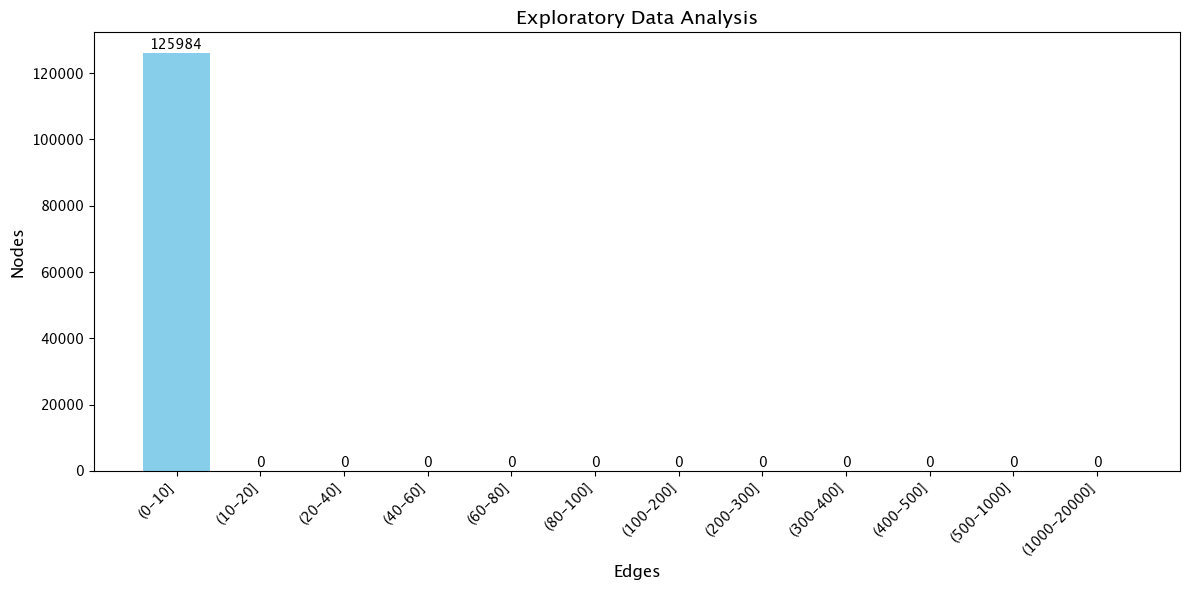

In [20]:
import matplotlib.pyplot as plt

bins = list(counts.keys())
values = list(counts.values())

plt.figure(figsize=(12, 6))
plt.bar(bins, values, color='skyblue')

for i, value in enumerate(values):
    plt.text(i, value + max(values) * 0.01, str(value), ha='center', fontsize=10)

plt.xlabel('Edges', fontsize=12)
plt.ylabel('Nodes', fontsize=12)
plt.title('Exploratory Data Analysis', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [21]:
count = 0
for edge in edges:
    count += 1
    if count == 10:
        break
    print(edge)

('EliBenSasson', 'Starknet')
('KittenHaimer', 'geojamofficial')
('soro', 'G7_DAO')
('soro', 'Immutable')
('bitpinas', '0xGenie')
('bitpinas', 'ismaeljerusalem')
('bitpinas', 'Duck_Chain')
('bitpinas', 'blumcrypto')
('bitpinas', 'bitgetglobal')


In [22]:
from scipy import sparse
from fast_pagerank import pagerank
from fast_pagerank import pagerank_power
import numpy as np

num_nodes = len(nodes)

node_to_index = {node: index for index, node in enumerate(nodes)}

edges_indices = [(node_to_index[u], node_to_index[v]) for u, v in edges]


A = np.array(edges_indices)
G = sparse.csr_matrix((weights, (A[:, 0], A[:, 1])), shape=(num_nodes, num_nodes))

print("Tính PageRank")
damping_factor = 0.85
pagerank_scores = pagerank(G, p=damping_factor)


Tính PageRank


In [23]:
pagerank_scores

array([6.25512921e-06, 6.25512921e-06, 6.25512921e-06, ...,
       7.37446812e-06, 7.43665361e-06, 7.50615505e-06])

In [24]:
import numpy as np

sorted_indices = np.argsort(pagerank_scores)[::-1]
sorted_scores = pagerank_scores[sorted_indices]
sorted_nodes = [nodes[i] for i in sorted_indices]


scaled_scores = sorted_scores * 10000

rank = 0
results = {}
for i, (username, score) in enumerate(zip(sorted_nodes, scaled_scores)):
    rank += 1
    # if rank > 10:
    #     break
    print(f"Hạng {i+1}: {username} - {score:.4f}")
    results[username] = score

Hạng 1: CryptoCwby - 0.1157
Hạng 2: PiedPiperAI - 0.1157
Hạng 3: nasmithan - 0.1157
Hạng 4: Gegagedigedag - 0.1157
Hạng 5: enginayyildiz28 - 0.1157
Hạng 6: hodliss - 0.1157
Hạng 7: IrrespBored - 0.1157
Hạng 8: zapcatofficial - 0.1157
Hạng 9: BuddyEvap - 0.1157
Hạng 10: masoncags - 0.1157
Hạng 11: 0xVictorP - 0.1157
Hạng 12: official_doom - 0.1157
Hạng 13: BlockcastNet - 0.1157
Hạng 14: russ5555555 - 0.1157
Hạng 15: holddoteth - 0.1157
Hạng 16: FilmgateMiami - 0.1157
Hạng 17: DogeXRPL - 0.1157
Hạng 18: ArloHotels - 0.1157
Hạng 19: Lalalunalina - 0.1157
Hạng 20: meowptain - 0.1157
Hạng 21: inSitesh - 0.1157
Hạng 22: botofluci - 0.1157
Hạng 23: AntonioJuliano - 0.1157
Hạng 24: AxinSpark - 0.1157
Hạng 25: Aras2Delica - 0.1157
Hạng 26: MINTemplePetrus - 0.1157
Hạng 27: GCrypto768 - 0.1157
Hạng 28: nataly_bon68912 - 0.1157
Hạng 29: toddgillelandp1 - 0.1157
Hạng 30: viva_la_vandal - 0.1157
Hạng 31: MorpheusSomnia - 0.1157
Hạng 32: SIGMAPSYOPS - 0.1157
Hạng 33: jean_chambras - 0.1157
Hạng 34: 

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [25]:
print(results)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [26]:
bins = [0, 1, 2, 3, 4, 5, 10, 20, 40, 60, 80, 100]
bin_labels = [f"({bins[i]}-{bins[i+1]}]" for i in range(len(bins) - 1)]

counts = {label: 0 for label in bin_labels}
for username, value in results.items():
    for i in range(len(bins) - 1):
        if bins[i] < value <= bins[i + 1]:
            counts[bin_labels[i]] += 1
            break

for bin_range, count in counts.items():
    print(f"{bin_range}: {count}")

(0-1]: 146194
(1-2]: 0
(2-3]: 0
(3-4]: 0
(4-5]: 0
(5-10]: 0
(10-20]: 0
(20-40]: 0
(40-60]: 0
(60-80]: 0
(80-100]: 0


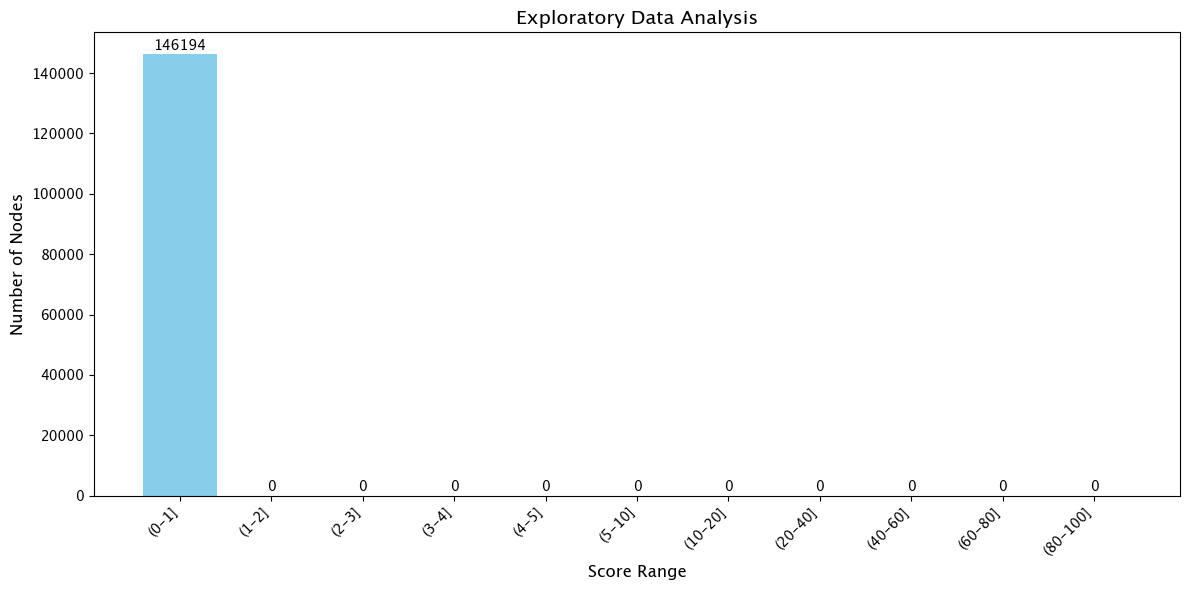

In [27]:
import matplotlib.pyplot as plt

bins = list(counts.keys())
values = list(counts.values())

plt.figure(figsize=(12, 6))
plt.bar(bins, values, color='skyblue')

for i, value in enumerate(values):
    plt.text(i, value + max(values) * 0.01, str(value), ha='center', fontsize=10)

plt.xlabel('Score Range', fontsize=12)
plt.ylabel('Number of Nodes', fontsize=12)
plt.title('Exploratory Data Analysis', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

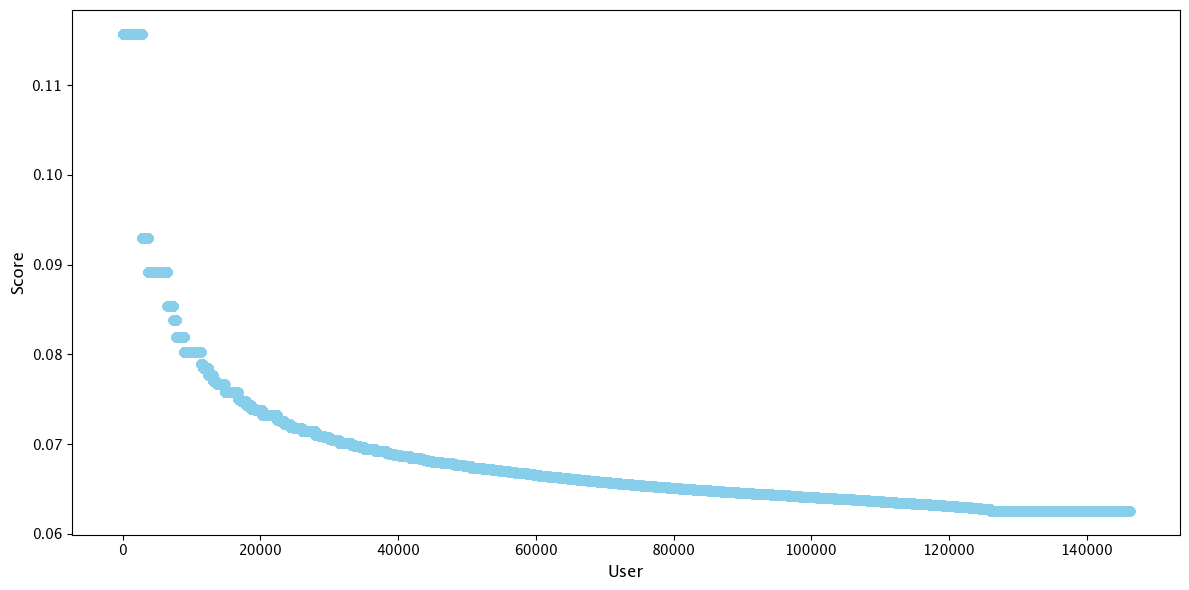

In [29]:
import requests

id = "bitcoin"
url = f"https://api.coingecko.com/api/v3/coins/{id}?localization=false&tickers=false&market_data=false&community_data=true&developer_data=false"

headers = {"accept": "application/json"}

response = requests.get(url, headers=headers)

print(response.text)

/Users/hieuhatrung/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


{"id":"bitcoin","symbol":"btc","name":"Bitcoin","web_slug":"bitcoin","asset_platform_id":null,"platforms":{"":""},"detail_platforms":{"":{"decimal_place":null,"contract_address":""}},"block_time_in_minutes":10,"hashing_algorithm":"SHA-256","categories":["Smart Contract Platform","Layer 1 (L1)","FTX Holdings","Proof of Work (PoW)","Bitcoin Ecosystem","GMCI 30 Index","GMCI Index","Coinbase 50 Index"],"preview_listing":false,"public_notice":null,"additional_notices":[],"description":{"en":"Bitcoin is the first successful internet money based on peer-to-peer technology; whereby no central bank or authority is involved in the transaction and production of the Bitcoin currency. It was created by an anonymous individual/group under the name, Satoshi Nakamoto. The source code is available publicly as an open source project, anybody can look at it and be part of the developmental process.\r\n\r\nBitcoin is changing the way we see money as we speak. The idea was to produce a means of exchange, i